In [132]:
import numpy as np
import matplotlib.pyplot as plt

In [133]:
### ---------Constantes del Láser ---------------
tauL = 10e-15 ## Duración Pulso Láser (10 fs)
wavelength = 1.032e-6 ## Longitud de onda (1.032 um)
I = 5.09e17 ## Irradiance~Intensity (W/m^2)
F = I * tauL
# ------------------------------------------------

### ---------Constantes del Aluminio ---------------
A = 1 - 0.94512 ## (1 - Reflectance) -> Transmitivity
gamma = 5.69e17 ## Acople electron-phonon (J/(m^3 K))
alpha = 2 * 9.6276*2*np.pi/1032e-9 ## Absorption Coefficient Aluminium (m ^-1)
pen_depth = 2/alpha
ball_length = 100e-9 ## Ballistic Length (100 nm)
Ci = 2.422e6 ## Capacidad Calorífica por unidad de volumen J/(m^3 K)

rho = 2700 ### Densidad (Kg/m^3)
Delta = 293/1000/0.026982 ### Specific Heat Evaporization (J / Kg)
# ------------------------------------------------

### ---------Constantes electrónicas ---------------
ke = 235 # Conductividad Térmica J /(m^3 K s)
Ce_aux = 134.5 ## Cte Capacidad Calorífica / volumen J/(m^2 K)
De = ke/Ce_aux*300

# ------------------------------------------------

### ---------Constantes Generales ---------------
Ia = I*A ## Irradiancia Absorbida (W/m^2)
Fa = Ia * tauL ## FLuence absorbida (J/m^2)
T0 = 300 ## Temperatura Inicial (K)
# ------------------------------------------------

## CONDICION PARA PODER USAR ECUACION
De*tauL < alpha**-2

False

### Femtosecond Pulses

#### Temperatura Electrónica

In [155]:
## INICIAMOS LOS TIEMPOS DE SIMULACIÓN t>= 0
start_t = 0
stop_t = tauL ## Duración del pulso láser, luego irá decayendo
dt = 0.01e-15 ## Pasos de 1 fs
### Creamos el FDTD para Z
start_z = 0
stop_z = 3e-8 ## Profundidad de 30 nm 
dz = 1e-11 ## Mallado de 0.01 nm

## Uso de Vectores y Mallado
t = np.linspace(start_t,stop_t,int((stop_t - start_t)/dt))
z = np.linspace(start_z, stop_z,int((stop_z-start_z)/dz))
tt, zz = np.meshgrid(t,z)

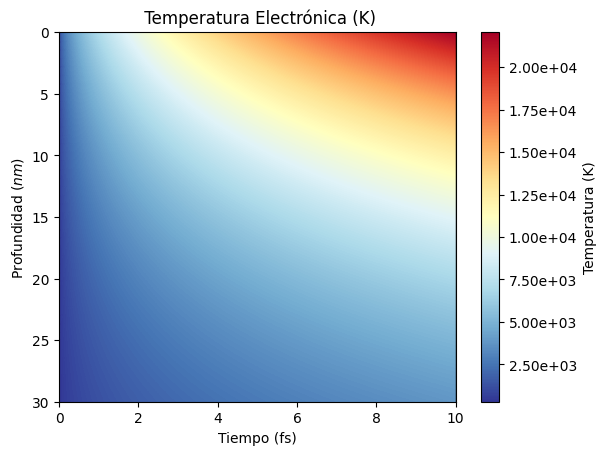

In [156]:
### ALMACENAMOS LAS TEMPERATURAS EN UNA MATRIZ
## TIENE LA FORMA Te[z[],t[]]
Te = ((T0**2 + ( 2 * Ia * alpha / Ce_aux ) * tt * np.exp( - alpha * zz ))**0.5)

im = plt.pcolor(tt*1e15, zz*1e9, Te, cmap = "RdYlBu_r")
plt.gca().invert_yaxis()
plt.axvline(x=tauL*1e15, ymin=0.0, ymax = 1, linewidth=1, color='k')
plt.xlabel("Tiempo (fs)")
plt.ylabel("Profundidad ($nm$)")
plt.title(" Temperatura Electrónica (K)" )
cbar = plt.colorbar(im, cmap = "RdYlBu_r",format= '%.2e')
cbar.set_label('Temperatura (K)', rotation=90)

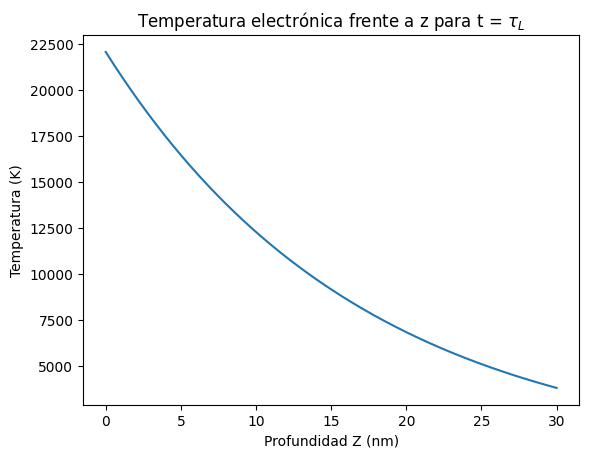

In [157]:
Te_tauL = ((2 * Ia * alpha/Ce_aux)* tauL)**0.5 * np.exp(-z/pen_depth)
plt.plot(z*1e9,Te_tauL)
plt.title(r"Temperatura electrónica frente a z para t = $\tau_L$ ")
plt.ylabel("Temperatura (K)")
plt.xlabel("Profundidad Z (nm)")
plt.show()

#### Temperatura Lattice

In [158]:
Ti = Te_tauL**2 * Ce_aux/(2 * Ci)

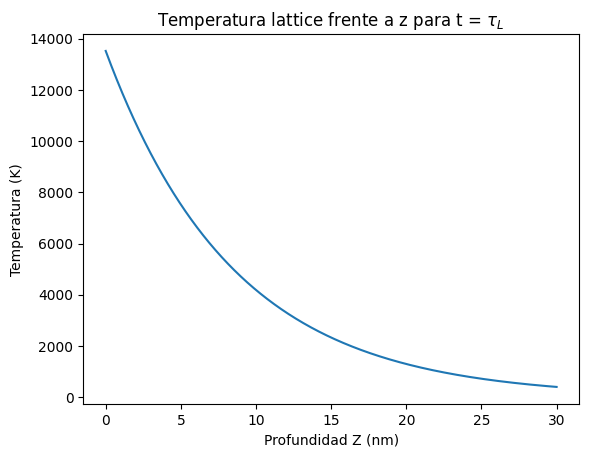

In [159]:
plt.plot(z*1e9,Ti)
plt.title(r"Temperatura lattice frente a z para t = $\tau_L$ ")
plt.ylabel("Temperatura (K)")
plt.xlabel("Profundidad Z (nm)")
plt.show()

### Threshold

In [160]:
Fth = rho*Delta / alpha

In [161]:
L = alpha**-1 * np.log(Fa/Fth)

In [162]:
print(f"Ablation Depth per pulse L= {L*1e6:.2f} \u03BCm ")

Ablation Depth per pulse L= 0.12 μm 


## Cálculo por PDE

In [168]:
t_stop = 1e-10
dt = 1e-12
t = np.linspace(tauL,t_stop,int((t_stop -tauL)/dt))

start_z = 0
stop_z = 3e-8 ## Profundidad de 1 um 
dz = 1e-11 ## Mallado de 0.1 nm
z = np.linspace(start_z,stop_z,int((stop_z-start_z)/dz))

Te = Te_tauL

Ti = np.ones_like(Te) * T0

Tenew = np.zeros_like(Te)
Tinew = np.zeros_like(Ti)

### FTCS

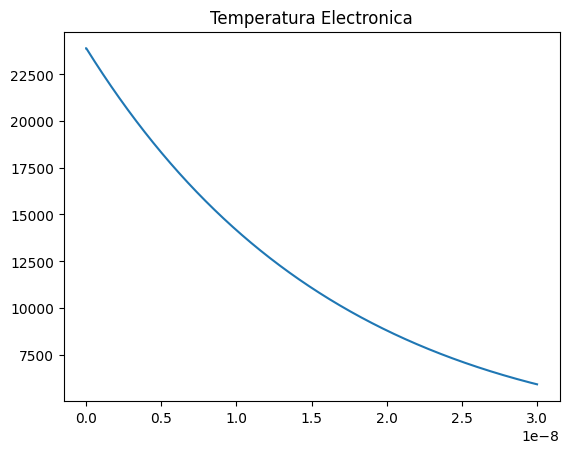

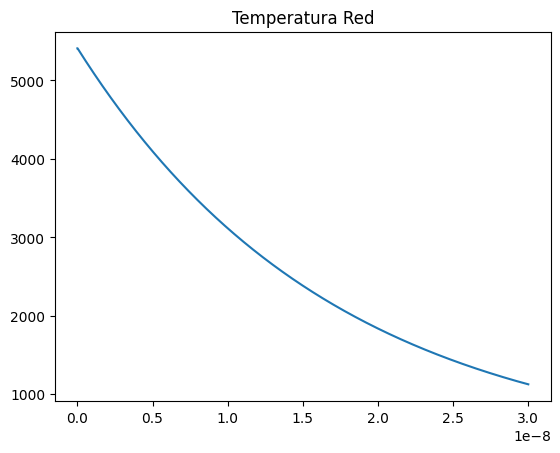

In [169]:
%matplotlib inline
for n in range(1):
    for i in range(1,len(z)-1):
        Tenew[i] = Te[i] + dt/Te[i]/Ce_aux * (
        ke*(Te[i-1]-2*Te[i]+Te[i+1])/dz**2 - gamma * (Te[i] - Ti[i]))
        Tinew[i] = Ti[i] + gamma * dt / Ci * (Te[i] - Ti[i])
        
    Tenew[0] = Tenew[1]
    Tenew[-1] = Tenew[-2]
    Tinew[0] = Tinew[1]
    Tinew[-1] = Tinew[-2]
    
    Te = Tenew
    Ti = Tinew
    if n%3 == 0 and n<60:
        plt.figure(1)
        im = plt.plot(z,Te)
        plt.title("Temperatura Electronica")
        plt.pause(0.01)
        plt.show
        
        plt.figure(2)
        im = plt.plot(z,Ti)
        plt.title("Temperatura Red")
        plt.pause(0.01)
        plt.show

### DuFort-Frankel

In [ ]:
for n in range(20):
    for i in range(1,len(z)-1):
        Tenew[i] = 2*dt/Te[i]/Ce * (
        ke * (Te[i-1] - Tnew)/dz/dz)